# Exploring tensorflow
I am getting confused when manipulating examples using tensorflow, so I am going to try to build up a VAE and train it line by line instead.

In [1]:
import tensorflow as tf
import numpy as np
tf.enable_eager_execution()

## VAE module
The variational autoencoder will expect a genotype vector as input. The idea is to learn genotype-set specific information from a sample by reducing it and then building it back up from a random generator. the structure of the program will be as follows:

1. VAE class 
    1. Model structure
    1. training methods 
1. example data training
1. data output

In [2]:
class VAE(tf.keras.Model):
    
    def __init__(self, n_latent=2, output_size=10): # default 2 latent dimensions
        super(VAE,self).__init__() # inherit Model functions
        self.n_latent=n_latent
        self.encode_net = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(128,activation=tf.nn.relu),
                tf.keras.layers.Dense(256,activation=tf.nn.relu),
                tf.keras.layers.Dense(2*n_latent) #no Activation
            ]
        )
        self.decode_net = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(n_latent,)),
                tf.keras.layers.Dense(256,activation=tf.nn.relu),
                tf.keras.layers.Dense(128,activation=tf.nn.relu),
                tf.keras.layers.Dense(output_size) #no Activation
            ]
        )
    
    def call(self, data):
        mean,logvar = self.encode(data)
        z = self.reparameterize(mean, logvar)
        return self.decode(z)

    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.n_latent))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encode_net(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid = False):
        logits = self.decode_net(z)
        if apply_sigmoid:
            return tf.sigmoid(logits)
        else:
            return logits
        
    def total_loss(self, x,y):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x_logit = self.decode(z)

        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
        logpx_z = -tf.reduce_sum(cross_ent)
        logpz = log_normal_pdf(z, 0., 0.)
        logqz_x = log_normal_pdf(z, mean, logvar)
        return -tf.reduce_mean(logpx_z + logpz - logqz_x)
    
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis
    )

### Generate some data

In [2]:
import gzip
def load_mnist_training():
    f = gzip.open('/home/wcasazza/scratch/MNIST/train-images-idx3-ubyte.gz','r')
    image_size = 28
    num_images = 60000
    f.read(16)
    buf = f.read(image_size * image_size * num_images)
    data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
    data = data.reshape(num_images, image_size, image_size, 1)
    return data

def load_mnist_test():
    f = gzip.open('/home/wcasazza/scratch/MNIST/t10k-images-idx3-ubyte.gz','r')
    image_size = 28
    num_images = 10000
    f.read(16)
    buf = f.read(image_size * image_size * num_images)
    data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
    data = data.reshape(num_images, image_size, image_size, 1)
    return data
    

train_images = load_mnist_training()
train_images = train_images.astype('float32') / 255
train_images = train_images.reshape((train_images.shape[0], 28 * 28))
test_images = load_mnist_test()
test_images = test_images.astype('float32') / 255
test_images = test_images.reshape((test_images.shape[0], 28 * 28))


# Binarization
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.


# train_data = np.random.binomial(2,0.25, size=(10000,1000)).astype(np.float32)
# test_data = np.random.binomial(2,0.25, size=(10000,1000)).astype(np.float32)

### Training
Only 3 lines!

In [14]:
model = VAE(n_latent=2, output_size=28*28)
model.compile(loss = model.total_loss, optimizer = tf.train.AdamOptimizer(1e-4), metrics=['accuracy', 'binary_crossentropy'])

In [16]:
with(tf.device('/gpu:0')):
    train_history = model.fit(train_images,train_images, epochs=100, batch_size=100,validation_data=(test_images, test_images), callbacks=[tf.keras.callbacks.TensorBoard()])

Epoch 1/100
600/600 [==============================] - 67s 111ms/step - loss: 22520.5937 - acc: 2.5000e-04 - binary_crossentropy: 1.7399 - val_loss: 20229.9260 - val_acc: 0.0000e+00 - val_binary_crossentropy: 1.7289
Epoch 2/100
600/600 [==============================] - 14s 24ms/step - loss: 19512.2005 - acc: 1.6667e-05 - binary_crossentropy: 1.7085 - val_loss: 18432.6656 - val_acc: 0.0000e+00 - val_binary_crossentropy: 1.6100
Epoch 3/100
600/600 [==============================] - 14s 24ms/step - loss: 18118.5551 - acc: 5.0000e-05 - binary_crossentropy: 1.5377 - val_loss: 17646.2203 - val_acc: 0.0000e+00 - val_binary_crossentropy: 1.4918
Epoch 4/100
600/600 [==============================] - 14s 24ms/step - loss: 17403.8429 - acc: 5.0000e-05 - binary_crossentropy: 1.4559 - val_loss: 17075.8400 - val_acc: 0.0000e+00 - val_binary_crossentropy: 1.4389
Epoch 5/100
600/600 [==============================] - 14s 24ms/step - loss: 16979.3025 - acc: 1.6667e-05 - binary_crossentropy: 1.3972 - v

### Generate some samples
**NOTE:** Need to think about what model architecture best suits my purposes
* The model below makes pretty rough looking samples
* Based on how the loss looks, the model training is okay
* Think about principled stopping conditions etc. for reproduceable usage in downstream CIT
* Think how (if at all) loss changes in genotype case, i.e. is binary crossentropy suitable?
* Think about how model architecture should change for "better" latent space

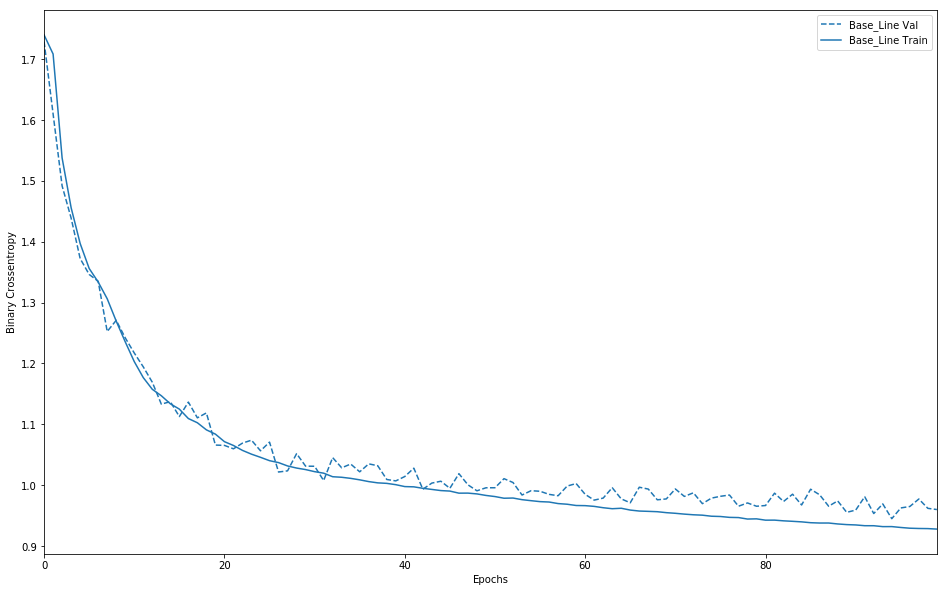

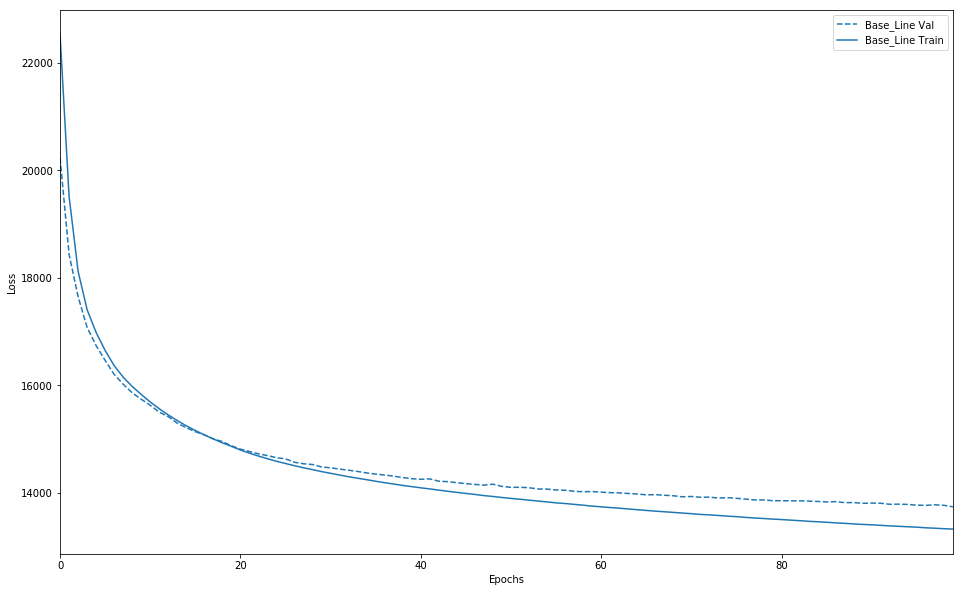

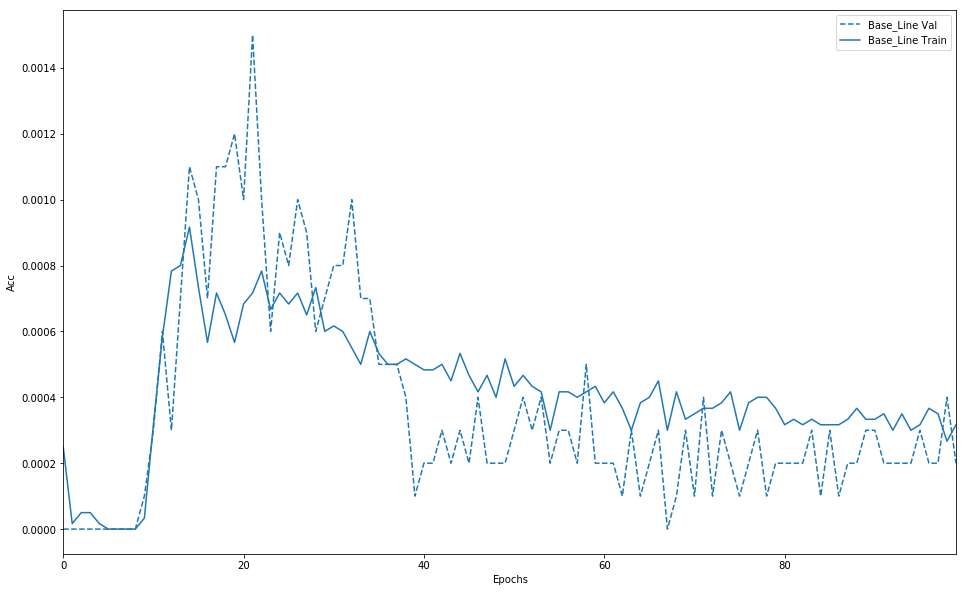

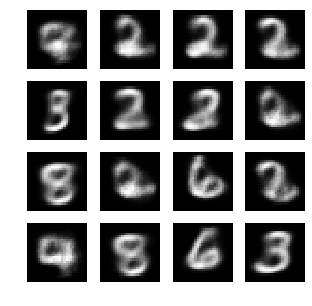

In [21]:
import matplotlib.pyplot as plt
def plot_history(histories, key='binary_crossentropy'):
    plt.figure(figsize=(16,10))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                       '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                 label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])

plot_history([("base_line", train_history)])
plot_history([("base_line", train_history)], key='loss')
plot_history([("base_line", train_history)], key = 'acc')


fig = plt.figure(figsize=(5,5))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(tf.reshape(model.sample(eps = tf.random.normal(shape = (1,2))),(28,28)),cmap="gray")
    plt.axis('off')
plt.show()

In [19]:
model.save_weights("/home/wcasazza/projects/def-saram/wcasazza/vaecit/scripts/mnist_test_weights.h5")

## MMD VAE
We can change the loss of our class above to get a model that better uses the latent space (and has clearer samples):

In [12]:
class MMD_VAE(tf.keras.Model):
    
    def __init__(self, n_latent=2, output_size=10): # default 2 latent dimensions
        super(MMD_VAE,self).__init__() # inherit Model functions
        self.n_latent=n_latent
        self.encode_net = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(128,activation=tf.nn.relu),
                tf.keras.layers.Dense(256,activation=tf.nn.relu),
                tf.keras.layers.Dense(n_latent) #no Activation
            ]
        )
        self.decode_net = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(n_latent,)),
                tf.keras.layers.Dense(256,activation=tf.nn.relu),
                tf.keras.layers.Dense(128,activation=tf.nn.relu),
                tf.keras.layers.Dense(output_size, activation = tf.nn.sigmoid) #no Activation
            ]
        )
    
    def call(self, data):
        z = self.encode(data)
        return self.decode(z)

    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.n_latent))
        return self.decode(eps)

    def encode(self, x):
        return self.encode_net(x)

    def decode(self, z):
        logits = self.decode_net(z)
        return logits
        
    def total_loss(self, x,y):
        train_z = self.encode_net(x)
        train_xr = self.decode_net(train_z)
        samples = tf.random_normal(tf.stack([200,self.n_latent]))
        loss_mmd = compute_mmd(samples,train_z)
        loss_nll = tf.reduce_mean(tf.square(train_xr - x))
        return loss_mmd + loss_nll
    
    
def compute_kernel(x, y):
    x_size = tf.shape(x)[0]
    y_size = tf.shape(y)[0]
    dim = tf.shape(x)[1]
    tiled_x = tf.tile(tf.reshape(x, tf.stack([x_size, 1, dim])), tf.stack([1, y_size, 1]))
    tiled_y = tf.tile(tf.reshape(y, tf.stack([1, y_size, dim])), tf.stack([x_size, 1, 1]))
    return tf.exp(-tf.reduce_mean(tf.square(tiled_x - tiled_y), axis=2) / tf.cast(dim, tf.float32))

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    return tf.reduce_mean(x_kernel) + tf.reduce_mean(y_kernel) - 2 * tf.reduce_mean(xy_kernel)

In [13]:
model = MMD_VAE(n_latent=2, output_size=28*28)
model.compile(loss = model.total_loss, optimizer = tf.train.AdamOptimizer(1e-4))
train_history = model.fit(train_images,train_images, epochs=100, batch_size=100)

Epoch 1/100
600/600 [==============================] - 13s 21ms/step - loss: 0.1532
Epoch 2/100
600/600 [==============================] - 13s 21ms/step - loss: 0.0919
Epoch 3/100
600/600 [==============================] - 12s 20ms/step - loss: 0.0889
Epoch 4/100
600/600 [==============================] - 13s 21ms/step - loss: 0.0872
Epoch 5/100
600/600 [==============================] - 12s 20ms/step - loss: 0.0861
Epoch 6/100
600/600 [==============================] - 12s 20ms/step - loss: 0.0840
Epoch 7/100
600/600 [==============================] - 12s 20ms/step - loss: 0.0840
Epoch 8/100
600/600 [==============================] - 12s 21ms/step - loss: 0.0826
Epoch 9/100
600/600 [==============================] - 12s 20ms/step - loss: 0.0822
Epoch 10/100
600/600 [==============================] - 13s 21ms/step - loss: 0.0811
Epoch 11/100
600/600 [==============================] - 12s 20ms/step - loss: 0.0801
Epoch 12/100
600/600 [==============================] - 12s 20ms/step - lo

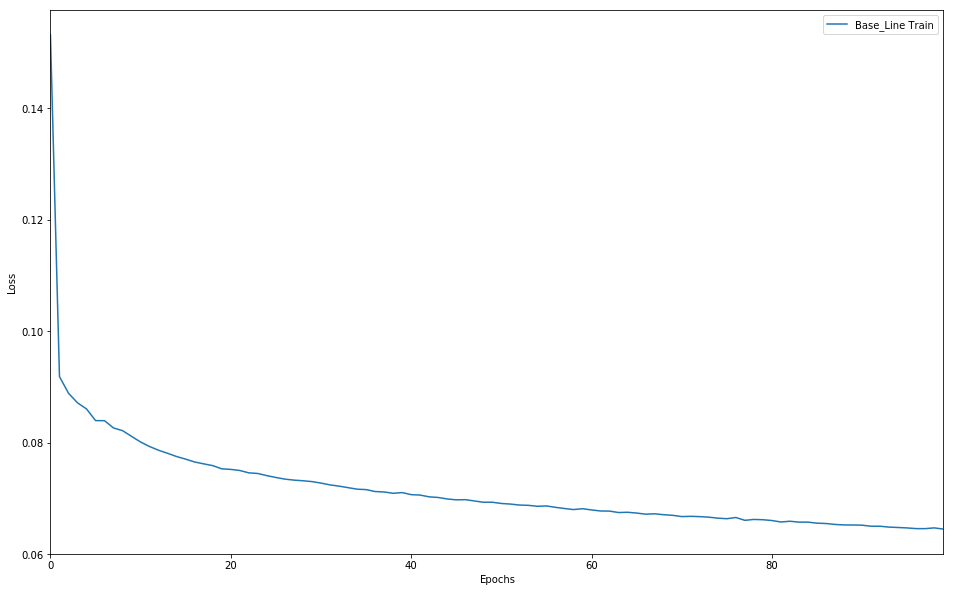

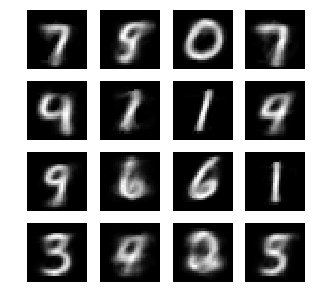

In [19]:
import matplotlib.pyplot as plt
def plot_history(histories, key='binary_crossentropy'):
    plt.figure(figsize=(16,10))

    for name, history in histories:
        plt.plot(history.epoch, history.history[key],
                 label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])

plot_history([("base_line", train_history)], key='loss')



fig = plt.figure(figsize=(5,5))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(tf.reshape(model.sample(eps = tf.random.normal(shape = (1,2))),(28,28)),cmap="gray")
    plt.axis('off')
plt.show()